Device to be used: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.98MB/s]


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Epoch 1/5
Mini batch 1, Loss: 73.8450
Mini batch 101, Loss: 17.7991
Mini batch 201, Loss: 6.8059
Mini batch 301, Loss: 3.1266
Mini batch 401, Loss: 1.3333
Mini batch 501, Loss: 2.4190
Mini batch 601, Loss: 6.2522
Mini batch 701, Loss: 1.8345
Mini batch 801, Loss: 5.5729
Mini batch 901, Loss: 3.0616
Mini batch 1001, Loss: 3.7206
Mini batch 1101, Loss: 2.5643
Mini batch 1201, Loss: 7.2838
Mini

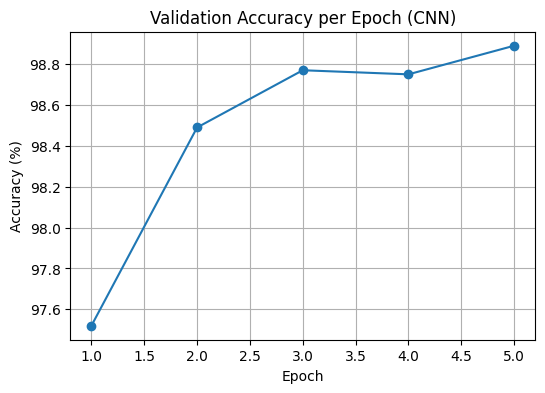

In [1]:
"""
This script demonstrates a simple transfer learning scenario using PyTorch.

Designed for teaching purposes to resemble examples from NVIDIA’s "Fundamentals of Deep Learning" training

Author: Dr. Olcay Kursun
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ------------------------------
# 1. Setup: random seeds and device
# ------------------------------
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device to be used:", device)

# ------------------------------
# 2. Load MNIST dataset
# ------------------------------
# Download training and test data (digits 0–9, 28x28 grayscale images)
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False)

# Define transformations (convert to tensor + small random rotation)
simple_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

train_dataset.transform = simple_transform
test_dataset.transform = simple_transform

# Wrap datasets into DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ------------------------------
# 3. Define the CNN model
# ------------------------------
# This CNN extracts spatial features via convolutional and pooling layers
# before using fully-connected layers for classification.

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # output: 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # output: 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # output: 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2)                              # output: 32x7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)                           # 10 output classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel().to(device)
print(model)

# ------------------------------
# 4. Loss function and optimizer
# ------------------------------
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------------
# 5. Training function (1 epoch)
# ------------------------------
def train_model():
    model.train()
    total_loss = 0
    batch = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Mini batch {batch+1}, Loss: {loss.item():.4f}")
        batch += 1

        total_loss += loss.item()

    print(f"Epoch average loss: {total_loss/len(train_dataset):.4f}")

# ------------------------------
# 6. Evaluation function
# ------------------------------
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# ------------------------------
# 7. Run training and evaluation
# ------------------------------
num_epochs = 5
accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_model()
    accuracy = evaluate_model(model)
    accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.2f}%")

# ------------------------------
# Plot accuracies
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), accuracies, marker='o')
plt.title("Validation Accuracy per Epoch (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


In [2]:
# ------------------------------
# Save pretrained model (after MNIST training)
# ------------------------------
save_path = "mnist_pretrained.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Saved MNIST pretrained model to {save_path}")


✅ Saved MNIST pretrained model to mnist_pretrained.pth


In [3]:
# ------------------------------
# Load pretrained MNIST model if exists
# ------------------------------
pretrained_path = "mnist_pretrained.pth"
model = CNNModel().to(device)

try:
    model.load_state_dict(torch.load(pretrained_path, map_location=device))
    print(f"✅ Loaded pretrained MNIST model from {pretrained_path}")
except FileNotFoundError:
    print("⚠️ No pretrained MNIST model found — training from scratch.")


✅ Loaded pretrained MNIST model from mnist_pretrained.pth


In [4]:
# ------------------------------
# 8. Tiny-Dataset Transfer Learning Demo
# ------------------------------
print("\n--- TRANSFER LEARNING with FEW SAMPLES: MNIST → Fashion-MNIST ---")

from torch.utils.data import Subset

# Load Fashion-MNIST
fashion_train_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=simple_transform)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=simple_transform)

# Create a tiny subset (e.g., 500 samples only)
tiny_indices = list(range(500))
fashion_tiny = Subset(fashion_train_full, tiny_indices)

tiny_loader = DataLoader(fashion_tiny, batch_size=16, shuffle=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=64)

# --- Transfer model setup ---
transfer_model = model  # reuse trained MNIST model
transfer_model.eval()

# Freeze feature extractor
for p in transfer_model.features.parameters():
    p.requires_grad = False

# Replace classifier head
transfer_model.classifier[-1] = nn.Linear(128, 10).to(device)

optimizer_transfer = optim.Adam(transfer_model.classifier.parameters(), lr=0.001)

def train_tiny(model, loader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Transfer] Epoch {epoch+1}, Loss={total_loss/len(loader):.4f}")

def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in fashion_test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

print("\nTraining transfer model on a small subset of Fashion-MNIST samples...")
train_tiny(transfer_model, tiny_loader, optimizer_transfer, epochs=3)
transfer_acc = evaluate(transfer_model)
print(f"Transfer few-shot accuracy: {transfer_acc:.2f}%")

# ------------------------------
# 9. Train From Scratch on the same subset of few examples (baseline)
# ------------------------------
print("\n--- BASELINE: Train from scratch on same small subset of samples ---")

baseline_model = CNNModel().to(device)
optimizer_base = optim.Adam(baseline_model.parameters(), lr=0.001)

print("Training scratch model on few samples...")
train_tiny(baseline_model, tiny_loader, optimizer_base, epochs=3)
baseline_acc = evaluate(baseline_model)
print(f"Scratch few-shot accuracy: {baseline_acc:.2f}%")

print("\n--------------- RESULT SUMMARY ----------------")
print(f"Transfer learning accuracy: {transfer_acc:.2f}%")
print(f"Scratch model accuracy    : {baseline_acc:.2f}%")
print("------------------------------------------------")



--- TRANSFER LEARNING with FEW SAMPLES: MNIST → Fashion-MNIST ---


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.33MB/s]



Training transfer model on a small subset of Fashion-MNIST samples...
[Transfer] Epoch 1, Loss=25.8302
[Transfer] Epoch 2, Loss=14.2065
[Transfer] Epoch 3, Loss=11.0278
Transfer few-shot accuracy: 72.51%

--- BASELINE: Train from scratch on same small subset of samples ---
Training scratch model on few samples...
[Transfer] Epoch 1, Loss=30.8706
[Transfer] Epoch 2, Loss=16.9595
[Transfer] Epoch 3, Loss=12.5351
Scratch few-shot accuracy: 61.82%

--------------- RESULT SUMMARY ----------------
Transfer learning accuracy: 72.51%
Scratch model accuracy    : 61.82%
------------------------------------------------
